## Named Entity Recognition using Bidirectional LSTMs with POS Tags

In this notebook we extend our bidirectional LSTM model for Named Entity Recognition using POS tags. The model incorporated the POS tags and performs better.

Dataset from Kaggle: https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus

Source website: https://www.depends-on-the-definition.com/introduction-named-entity-recognition-python/

In [15]:
import pandas as pd
import numpy as np

data = pd.read_csv("data/ner_dataset.csv", encoding="latin1")

In [16]:
data = data.fillna(method="ffill")

In [17]:
data.tail(10)

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [18]:
words = list(set(data["Word"].values))
words.append("ENDPAD")

In [19]:
print(len(list(data["Word"].values)))

1048575


In [6]:
n_words = len(words); n_words

35179

In [7]:
tags = list(set(data["Tag"].values))

In [8]:
n_tags = len(tags); n_tags

17

In [9]:
pos_tags = list(set(data["POS"].values))

In [10]:
n_pos_tags = len(pos_tags); n_pos_tags

42

So we have 47959 sentences containing 35178 different words with 17 different tags. We use the SentenceGetter class from last post to retrieve sentences with their labels.

In [11]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [12]:
getter = SentenceGetter(data)

In [13]:
sent = getter.get_next()

In [13]:
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [14]:
sentences = getter.sentences

In [15]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

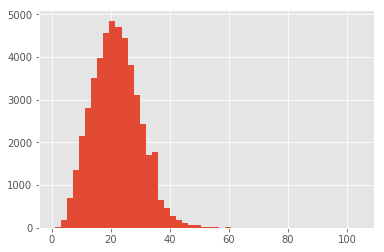

In [16]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

For the use of neural nets (at least with keras, this is no theoretical reason) we need to use equal-lenght input sequences. So we are going to pad our sentences to a length of 50. But first we need dictionaries of words and tags.

In [17]:
max_len = 50
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
pos2idx = {p: i for i, p in enumerate(pos_tags)}

In [18]:
word2idx["Obama"]

25588

In [19]:
tag2idx["B-geo"]

9

In [20]:
pos2idx["NNS"]

5

Now we map the senctences to a sequence of numbers and then pad the sequence.

In [21]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]

Using TensorFlow backend.


In [22]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)

In [24]:
from keras.preprocessing.sequence import pad_sequences
X_pos = [[pos2idx[w[1]] for w in s] for s in sentences]

In [25]:
X_pos = pad_sequences(maxlen=max_len, sequences=X_pos, padding="post", value=0)

In [26]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]

In [27]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [28]:
from keras.utils import to_categorical

For training the network we also need to change the labels y to categorial.

In [29]:
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [30]:
from sklearn.model_selection import train_test_split

In [1]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=2018)
X_pos_tr, X_pos_te, _, _ = train_test_split(X_pos, y, test_size=0.3, random_state=2018)

NameError: name 'train_test_split' is not defined

Now we can fit a LSTM network with an embedding layer. Note that we used the functional API of keras here, as it is more suitable for complicated architectures.

In [32]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, concatenate, Dense, TimeDistributed, Dropout, Bidirectional

In [36]:
word_input = Input(shape=(max_len,))
word_emb = Embedding(input_dim=n_words, output_dim=50, input_length=max_len, mask_zero=True)(word_input)

pos_input = Input(shape=(max_len,))
pos_emb = Embedding(input_dim=n_pos_tags+2, output_dim=50,
                    input_length=max_len, mask_zero=True)(pos_input)

model = concatenate([word_emb, pos_emb])
model = Dropout(0.5)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.5))(model)

out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

In [37]:
model = Model([word_input, pos_input], out)

In [38]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [40]:
history = model.fit([X_tr,X_pos_tr], np.array(y_tr), batch_size=32, epochs=5, validation_split=0.1, verbose=1)

Train on 38846 samples, validate on 4317 samples
Epoch 1/5
38846/38846 [==============================] - 239s 6ms/step - loss: 0.2196 - acc: 0.9417 - val_loss: 0.1154 - val_acc: 0.9655
Epoch 2/5
38846/38846 [==============================] - 198s 5ms/step - loss: 0.1032 - acc: 0.9690 - val_loss: 0.1005 - val_acc: 0.9698
Epoch 3/5
38846/38846 [==============================] - 189s 5ms/step - loss: 0.0901 - acc: 0.9726 - val_loss: 0.0974 - val_acc: 0.9704
Epoch 4/5
38846/38846 [==============================] - 190s 5ms/step - loss: 0.0827 - acc: 0.9748 - val_loss: 0.0933 - val_acc: 0.9712
Epoch 5/5
38846/38846 [==============================] - 187s 5ms/step - loss: 0.0780 - acc: 0.9762 - val_loss: 0.0914 - val_acc: 0.9720


In [61]:
hist = pd.DataFrame(history.history)

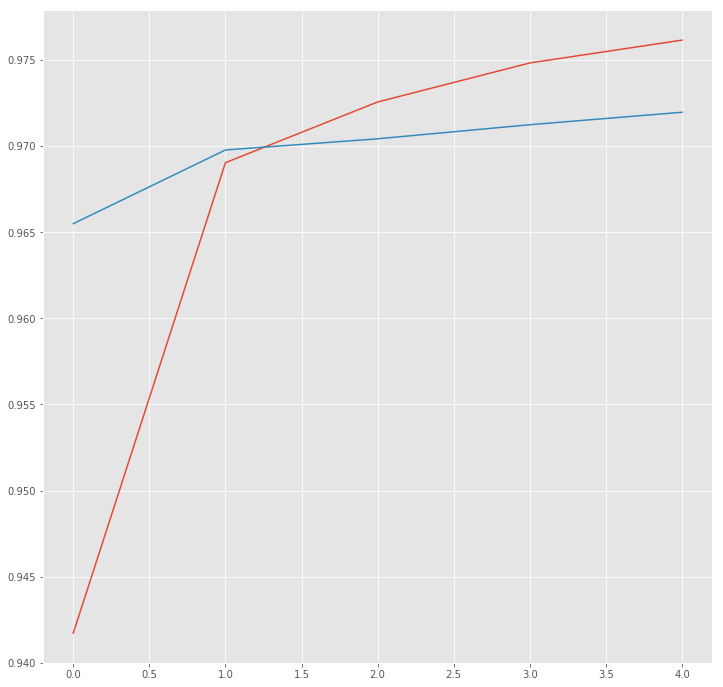

In [42]:
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

Now let us look at some predictions.

In [58]:
i = 1000
pred = model.predict([X_te, X_pos_te])
#print(pred[i])      
p = np.argmax(pred[i], axis=-1)
true = np.argmax(y_te[i], -1)
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w, t, pred in zip(X_te[i], true, p):
    print("{:15}: {:5} {}".format(words[w], tags[t], tags[pred]))

Word            (True ): Pred
The            : O     O
US             : B-org B-org
Government     : I-org O
is             : O     O
also           : O     O
a              : O     O
major          : O     O
revenue        : O     O
source         : O     O
for            : O     O
Tuvalu         : B-org B-org
because        : O     O
of             : O     O
payments       : O     O
from           : O     O
a              : O     O
1988           : B-tim B-tim
treaty         : O     O
on             : O     O
fisheries      : O     O
.              : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD  

In [59]:
# import os

# model.save_weights("saved files/NER using LSTM-2(100 units)")

In [62]:

# import pickle

# filename = "saved files/NER using LSTM-2(100 units) HISTORY.hdf5"
# pickle.dump(hist, open(filename, 'wb'))